In [9]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Device (CUDA / MPS / CPU)
device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

In [3]:
### transforming images
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), ### apply data augmentation 
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),  # keeping the original image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [4]:
dataset_path = "FRUIT-16K"

dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

16000

In [5]:
### Prints all class and number of classes
num_of_classes = len(dataset.classes)
print(dataset.classes)
print(num_of_classes)

['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']
16


In [6]:
#train test split
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_size,val_size

(12000, 4000)

In [7]:
### creating batch
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [8]:
### checking the shape of images and labels
for images,labels in train_dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776908].


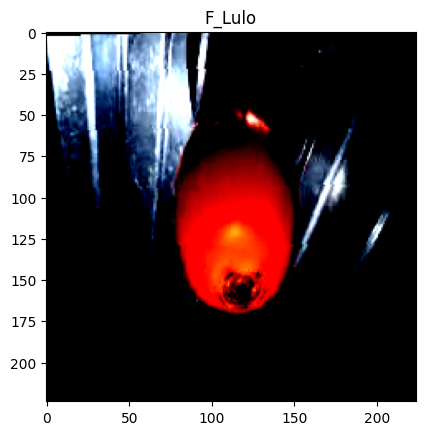

In [12]:
### visualizing a image
plt.imshow(images[0].permute(1, 2, 0))
plt.title(dataset.classes[labels[0]])
plt.show()

In [51]:
class freshnessClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (32, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [11]:
class freshnessClassifierWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [18]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 30 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

### CNN

In [ ]:
# Initialization of the model
model = freshnessClassifierCNN(num_of_classes).to(device)
# Multi-class classification
criterion = nn.CrossEntropyLoss()

# Common optimizers
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [54]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=15)

Batch: 30, Epoch: 1, Loss: 2.72
Batch: 60, Epoch: 1, Loss: 2.38
Batch: 90, Epoch: 1, Loss: 1.72
Batch: 120, Epoch: 1, Loss: 1.42
Batch: 150, Epoch: 1, Loss: 1.41
Batch: 180, Epoch: 1, Loss: 1.35
Batch: 210, Epoch: 1, Loss: 1.44
Batch: 240, Epoch: 1, Loss: 1.10
Batch: 270, Epoch: 1, Loss: 0.87
Batch: 300, Epoch: 1, Loss: 0.98
Batch: 330, Epoch: 1, Loss: 0.81
Batch: 360, Epoch: 1, Loss: 0.55
Epoch [1/15], Avg Loss: 1.4931
*** Validation Accuracy: 66.05% ***
Batch: 30, Epoch: 2, Loss: 0.89
Batch: 60, Epoch: 2, Loss: 1.00
Batch: 90, Epoch: 2, Loss: 0.92
Batch: 120, Epoch: 2, Loss: 1.19
Batch: 150, Epoch: 2, Loss: 0.83
Batch: 180, Epoch: 2, Loss: 0.89
Batch: 210, Epoch: 2, Loss: 0.94
Batch: 240, Epoch: 2, Loss: 0.65
Batch: 270, Epoch: 2, Loss: 0.69
Batch: 300, Epoch: 2, Loss: 0.87
Batch: 330, Epoch: 2, Loss: 0.61
Batch: 360, Epoch: 2, Loss: 0.18
Epoch [2/15], Avg Loss: 0.7312
*** Validation Accuracy: 76.90% ***
Batch: 30, Epoch: 3, Loss: 0.64
Batch: 60, Epoch: 3, Loss: 0.85
Batch: 90, Epoch

With each epoch average loss in decreasing and validation accuracy is increasing this suggests our model is not overfitting.
Also if our model were underfitting we would have seen more loss to be higher and accuracy to be lower. 
So we can safely say that our model is a balanced model. 

### CNN with Regularization

In [ ]:
# Initialization of the model with regularization
model = freshnessClassifierWithRegularization(num_of_classes).to(device)
# Multi-class classification
criterion = nn.CrossEntropyLoss()

# optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001) -> 83% accuracy
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Adding weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)  

In [60]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=15)

Batch: 30, Epoch: 1, Loss: 2.82
Batch: 60, Epoch: 1, Loss: 2.50
Batch: 90, Epoch: 1, Loss: 2.35
Batch: 120, Epoch: 1, Loss: 2.54
Batch: 150, Epoch: 1, Loss: 2.20
Batch: 180, Epoch: 1, Loss: 2.69
Batch: 210, Epoch: 1, Loss: 2.34
Batch: 240, Epoch: 1, Loss: 2.24
Batch: 270, Epoch: 1, Loss: 1.86
Batch: 300, Epoch: 1, Loss: 1.56
Batch: 330, Epoch: 1, Loss: 1.93
Batch: 360, Epoch: 1, Loss: 2.36
Epoch [1/15], Avg Loss: 2.9530
*** Validation Accuracy: 39.45% ***
Batch: 30, Epoch: 2, Loss: 1.98
Batch: 60, Epoch: 2, Loss: 2.25
Batch: 90, Epoch: 2, Loss: 1.92
Batch: 120, Epoch: 2, Loss: 1.90
Batch: 150, Epoch: 2, Loss: 2.01
Batch: 180, Epoch: 2, Loss: 1.87
Batch: 210, Epoch: 2, Loss: 2.17
Batch: 240, Epoch: 2, Loss: 1.54
Batch: 270, Epoch: 2, Loss: 1.74
Batch: 300, Epoch: 2, Loss: 2.26
Batch: 330, Epoch: 2, Loss: 2.18
Batch: 360, Epoch: 2, Loss: 1.97
Epoch [2/15], Avg Loss: 1.9931
*** Validation Accuracy: 44.25% ***
Batch: 30, Epoch: 3, Loss: 1.59
Batch: 60, Epoch: 3, Loss: 1.84
Batch: 90, Epoch

Regularized model is also a balanced model but accuracy is lower than the non regularized model.
So our model accuracy did not improve.

### EfficientNet

In [68]:
class freshnessClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False  # Freeze the pre-trained weights
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [69]:
## model initialization
model_EfficientNET = freshnessClassifierEfficientNet(num_of_classes).to(device)
criterion = nn.CrossEntropyLoss()
### optimize only the parameters that require gradients
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model_EfficientNET.parameters()),lr=0.001) 

In [71]:
all_labels, all_predictions = train_model(model_EfficientNET, criterion, optimizer, epochs=15)

Batch: 30, Epoch: 1, Loss: 0.30
Batch: 60, Epoch: 1, Loss: 0.29
Batch: 90, Epoch: 1, Loss: 0.21
Batch: 120, Epoch: 1, Loss: 0.32
Batch: 150, Epoch: 1, Loss: 0.26
Batch: 180, Epoch: 1, Loss: 0.31
Batch: 210, Epoch: 1, Loss: 0.18
Batch: 240, Epoch: 1, Loss: 0.24
Batch: 270, Epoch: 1, Loss: 0.34
Batch: 300, Epoch: 1, Loss: 0.25
Batch: 330, Epoch: 1, Loss: 0.17
Batch: 360, Epoch: 1, Loss: 0.25
Epoch [1/15], Avg Loss: 0.2538
*** Validation Accuracy: 98.17% ***
Batch: 30, Epoch: 2, Loss: 0.16
Batch: 60, Epoch: 2, Loss: 0.12
Batch: 90, Epoch: 2, Loss: 0.15
Batch: 120, Epoch: 2, Loss: 0.17
Batch: 150, Epoch: 2, Loss: 0.18
Batch: 180, Epoch: 2, Loss: 0.13
Batch: 210, Epoch: 2, Loss: 0.28
Batch: 240, Epoch: 2, Loss: 0.19
Batch: 270, Epoch: 2, Loss: 0.13
Batch: 300, Epoch: 2, Loss: 0.13
Batch: 330, Epoch: 2, Loss: 0.08
Batch: 360, Epoch: 2, Loss: 0.15
Epoch [2/15], Avg Loss: 0.1832
*** Validation Accuracy: 98.60% ***
Batch: 30, Epoch: 3, Loss: 0.13
Batch: 60, Epoch: 3, Loss: 0.12
Batch: 90, Epoch

### ResNet

In [19]:
class freshnessClassifierResNet(nn.Module):
    def __init__(self, num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False  # Freeze the pre-trained weights
        
        ## unfreeze the last layer for learning new features
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [20]:
## model initialization
model_ResNet = freshnessClassifierResNet(num_of_classes,dropout_rate=0.5791).to(device)
criterion = nn.CrossEntropyLoss()
### optimize only the parameters that require gradients
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model_ResNet.parameters()),lr=0.000244) 

In [21]:
all_labels, all_predictions = train_model(model_ResNet, criterion, optimizer, epochs=5)

Batch: 30, Epoch: 1, Loss: 1.59
Batch: 60, Epoch: 1, Loss: 0.19
Batch: 90, Epoch: 1, Loss: 0.03
Batch: 120, Epoch: 1, Loss: 0.10
Batch: 150, Epoch: 1, Loss: 0.02
Batch: 180, Epoch: 1, Loss: 0.13
Batch: 210, Epoch: 1, Loss: 0.15
Batch: 240, Epoch: 1, Loss: 0.07
Batch: 270, Epoch: 1, Loss: 0.06
Batch: 300, Epoch: 1, Loss: 0.07
Batch: 330, Epoch: 1, Loss: 0.09
Batch: 360, Epoch: 1, Loss: 0.03
Epoch [1/5], Avg Loss: 0.2924
*** Validation Accuracy: 99.60% ***
Batch: 30, Epoch: 2, Loss: 0.04
Batch: 60, Epoch: 2, Loss: 0.07
Batch: 90, Epoch: 2, Loss: 0.03
Batch: 120, Epoch: 2, Loss: 0.01
Batch: 150, Epoch: 2, Loss: 0.00
Batch: 180, Epoch: 2, Loss: 0.01
Batch: 210, Epoch: 2, Loss: 0.01
Batch: 240, Epoch: 2, Loss: 0.02
Batch: 270, Epoch: 2, Loss: 0.00
Batch: 300, Epoch: 2, Loss: 0.01
Batch: 330, Epoch: 2, Loss: 0.02
Batch: 360, Epoch: 2, Loss: 0.01
Epoch [2/5], Avg Loss: 0.0336
*** Validation Accuracy: 99.83% ***
Batch: 30, Epoch: 3, Loss: 0.00
Batch: 60, Epoch: 3, Loss: 0.01
Batch: 90, Epoch: 

In [22]:
report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       265
           1       1.00      1.00      1.00       244
           2       1.00      1.00      1.00       265
           3       1.00      1.00      1.00       254
           4       1.00      1.00      1.00       227
           5       1.00      1.00      1.00       246
           6       1.00      1.00      1.00       260
           7       1.00      1.00      1.00       255
           8       1.00      1.00      1.00       256
           9       1.00      1.00      1.00       252
          10       1.00      1.00      1.00       229
          11       1.00      1.00      1.00       257
          12       1.00      1.00      1.00       252
          13       1.00      1.00      1.00       242
          14       1.00      1.00      1.00       251
          15       1.00      1.00      1.00       245

    accuracy                           1.00      4000
   macro avg       1.00   

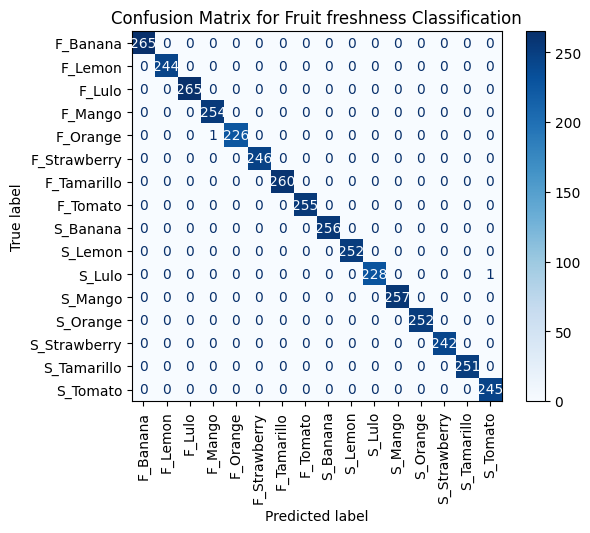

In [23]:
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_of_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix for Fruit freshness Classification")
plt.show()

### Optuna

Resnet is giving the best accuracy now will find best hyper parameters for resNet.

In [14]:

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Load the model
    model = freshnessClassifierResNet(num_classes=num_of_classes, dropout_rate=dropout_rate).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)

        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return accuracy

In [15]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-07-27 19:31:12,389] A new study created in memory with name: no-name-ea47d0c9-8f5d-4a5a-97d0-d7391aa4e55b
[I 2025-07-27 20:19:32,068] Trial 0 finished with value: 99.825 and parameters: {'lr': 0.00024464047141287376, 'dropout_rate': 0.57919944507662}. Best is trial 0 with value: 99.825.


Execution time: 2899.3600544929504 seconds


[I 2025-07-27 21:08:04,993] Trial 1 finished with value: 99.65 and parameters: {'lr': 0.0001086669185636976, 'dropout_rate': 0.32211865639892356}. Best is trial 0 with value: 99.825.


Execution time: 2912.5907661914825 seconds


[W 2025-07-27 21:12:40,513] Trial 2 failed with parameters: {'lr': 3.3189652660742274e-05, 'dropout_rate': 0.3532579883836918} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Study\RESOURCES\MATERIALS\Codebasics\DS and AI\Project\Deep Learning\.venv\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\amana\AppData\Local\Temp\ipykernel_11072\3676535728.py", line 24, in objective
    outputs = model(images)
  File "d:\Study\RESOURCES\MATERIALS\Codebasics\DS and AI\Project\Deep Learning\.venv\lib\site-packages\torch\nn\modules\module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "d:\Study\RESOURCES\MATERIALS\Codebasics\DS and AI\Project\Deep Learning\.venv\lib\site-packages\torch\nn\modules\module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\amana\AppData\Local\Temp\ipykernel_11072\3891

KeyboardInterrupt: 

In [16]:
study.best_params, study.best_value

({'lr': 0.00024464047141287376, 'dropout_rate': 0.57919944507662}, 99.825)

Without optuna ResNet model was 90.80% accuracy with dropout 50% and lr = 0.001.
Now will train resNet again using the optuna suggested hyper-parameters. 

In [19]:
torch.save(model_ResNet.state_dict(), 'saved_model.pth')